In [47]:
import json
import os
import numpy as np
import pandas as pd
import torch
import joblib
import re
import textstat
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel, pipeline

In [48]:
def preprocess_text_bert_input(text):
    text = text.lower()
    text = re.sub(r"<[^>]+>", " ", text)
    return re.sub(r"\s+", " ", text).strip()

# New data loader for the specific JSON format of TOEFL/Hewlett
def load_document_json(filepath):
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
        texts = [item['document'] for item in data if 'document' in item]
        return texts
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return []
    
# Stylometry functions 
FEATURE_NAMES = ['flesch_reading_ease', 'flesch_kincaid_grade', 'gunning_fog', 'smog_index', 'automated_readability_index', 'coleman_liau_index', 'lexicon_count', 'sentence_count', 'avg_sentence_length', 'avg_word_length', 'type_token_ratio']
def extract_stylometric_features(text: str) -> np.ndarray:
    if not text or len(text.split()) < 3: return np.zeros(len(FEATURE_NAMES))
    try:
        features = [
            textstat.flesch_reading_ease(text), textstat.flesch_kincaid_grade(text),
            textstat.gunning_fog(text), textstat.smog_index(text),
            textstat.automated_readability_index(text), textstat.coleman_liau_index(text),
            textstat.lexicon_count(text), textstat.sentence_count(text),
            textstat.avg_sentence_length(text), textstat.avg_word_length(text),
        ]
        words = text.lower().split(); ttr = len(set(words)) / len(words) if len(words) > 0 else 0
        features.append(ttr)
        return np.array(features, dtype=np.float32)
    except Exception: return np.zeros(len(FEATURE_NAMES))

In [49]:
BERT_MODEL_DIR = "./bert_ai_detector_final"
NAIVE_BAYES_MODEL_PATH = "baseline_saved_model/naive_bayes_model.joblib"
NAIVE_BAYES_VECTORIZER_PATH = "baseline_saved_model/tfidf_vectorizer.joblib"
HYBRID_CLASSIFIER_PATH = "hybrid_model/hybrid_classifier.joblib"
SCALER_PATH = "hybrid_model/feature_scaler.joblib"
OUTPUT_DIR = "ethics_analysis_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'cuda:0' if device == 0 else 'cpu'}.")

# Load models
nb_clf = joblib.load(NAIVE_BAYES_MODEL_PATH)
tfidf_vec = joblib.load(NAIVE_BAYES_VECTORIZER_PATH)
bert_pipeline = pipeline("text-classification", model=BERT_MODEL_DIR, tokenizer=BERT_MODEL_DIR, device=device)
hybrid_clf = joblib.load(HYBRID_CLASSIFIER_PATH)
scaler = joblib.load(SCALER_PATH)
bert_base_model = AutoModel.from_pretrained(BERT_MODEL_DIR).to(device).eval()
bert_base_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_DIR)

Using device: cuda:0.


Device set to use cuda:0


In [50]:
def get_bert_predictions(texts, pipeline_obj):
    processed_texts = [preprocess_text_bert_input(t) for t in texts]
    preds_raw = pipeline_obj(processed_texts, truncation=True, padding=True, max_length=256, top_k=None)
    
    id2label = pipeline_obj.model.config.id2label
    label_1_str = id2label[1] # Assumes label 1 is the "AI" class
    
    probs = []
    for item_pred_list in preds_raw:
        score_dict = {p['label']: p['score'] for p in item_pred_list}
        prob_1 = score_dict.get(label_1_str, 0.0)
        probs.append(prob_1)
    return probs

def get_hybrid_predictions(texts, base_bert_model, tokenizer, scaler, final_classifier, device):
    bert_feats = []
    with torch.no_grad():
        for text in tqdm(texts, desc="Hybrid Feats"):
            inputs = tokenizer(preprocess_text_bert_input(text), return_tensors="pt", truncation=True, max_length=256).to(device)
            outputs = base_bert_model(**inputs)
            bert_feats.append(outputs.last_hidden_state[:, 0, :].cpu().numpy().squeeze())
    
    style_feats = np.array([extract_stylometric_features(t) for t in texts])
    X_hybrid = np.concatenate([np.array(bert_feats), style_feats], axis=1)
    X_hybrid_scaled = scaler.transform(X_hybrid)
    
    probs = final_classifier.predict_proba(X_hybrid_scaled)[:, 1] # Probability of AI class
    return probs.tolist()


 Dataset: TOEFL Essays
Loaded 91 documents.


Hybrid Feats:   0%|          | 0/91 [00:00<?, ?it/s]

C:\Users\shaya\AppData\Local\Temp\ipykernel_20696\2131865983.py:27: DeprecationWarning: The 'avg_sentence_length' method has been deprecated due to being the same as 'words_per_sentence'. This method will be removed in thefuture.
  textstat.avg_sentence_length(text), textstat.avg_word_length(text),



Analysis plots saved to ethics_analysis_outputs\ethics_bias_analysis.png


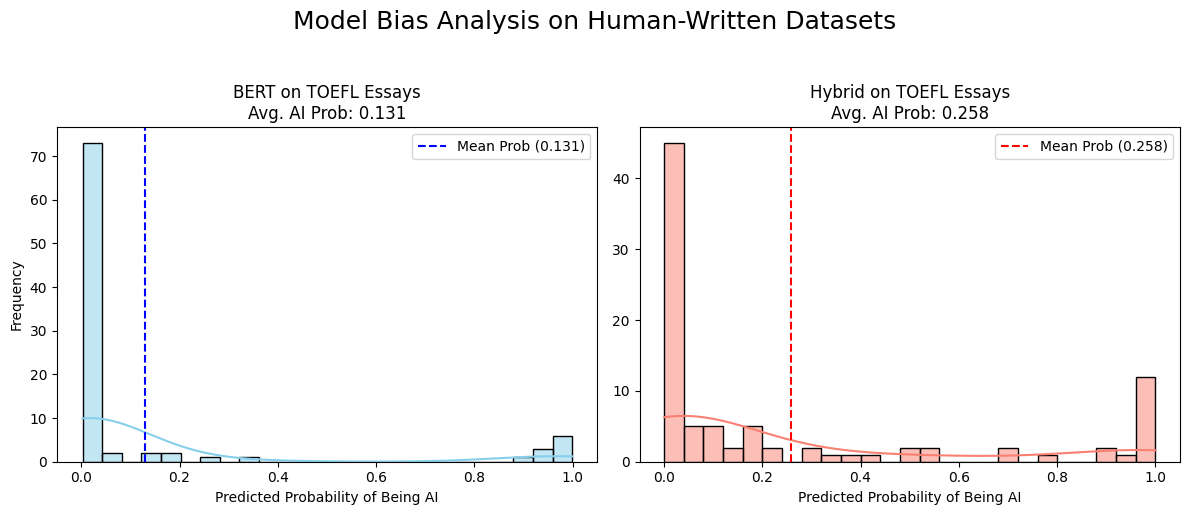

In [51]:
ethics_files = {
    "TOEFL Essays": "./devset/toefl.json"
}

all_predictions = {}

for name, path in ethics_files.items():
    print(f"\n Dataset: {name}")
    texts = load_document_json(path)
    if not texts:
        continue
    
    print(f"Loaded {len(texts)} documents.")
    bert_probs = get_bert_predictions(texts, bert_pipeline)
    hybrid_probs = get_hybrid_predictions(texts, bert_base_model, bert_base_tokenizer, scaler, hybrid_clf, device)
    
    all_predictions[name] = {
        "BERT-only": bert_probs,
        "Hybrid-MLP": hybrid_probs
    }

if not all_predictions:
    pass
else:
    num_datasets = len(all_predictions)
    fig, axes = plt.subplots(num_datasets, 2, figsize=(12, 5 * num_datasets), sharex=True)
    fig.suptitle('Model Bias Analysis on Human-Written Datasets', fontsize=18, y=1.02)

    if num_datasets == 1:
        axes = np.array([axes])

    for i, (dataset_name, model_preds) in enumerate(all_predictions.items()):
        ax1 = axes[i, 0]
        sns.histplot(model_preds["BERT-only"], bins=25, ax=ax1, color='skyblue', kde=True)
        bert_avg_prob = np.mean(model_preds["BERT-only"])
        ax1.set_title(f'BERT on {dataset_name}\nAvg. AI Prob: {bert_avg_prob:.3f}', fontsize=12)
        ax1.set_xlabel('Predicted Probability of Being AI')
        ax1.set_ylabel('Frequency')
        ax1.axvline(bert_avg_prob, color='blue', linestyle='--', label=f'Mean Prob ({bert_avg_prob:.3f})')
        ax1.legend()

        ax2 = axes[i, 1]
        sns.histplot(model_preds["Hybrid-MLP"], bins=25, ax=ax2, color='salmon', kde=True)
        hybrid_avg_prob = np.mean(model_preds["Hybrid-MLP"])
        ax2.set_title(f'Hybrid on {dataset_name}\nAvg. AI Prob: {hybrid_avg_prob:.3f}', fontsize=12)
        ax2.set_xlabel('Predicted Probability of Being AI')
        ax2.set_ylabel('')
        ax2.axvline(hybrid_avg_prob, color='red', linestyle='--', label=f'Mean Prob ({hybrid_avg_prob:.3f})')
        ax2.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plot_save_path = os.path.join(OUTPUT_DIR, "ethics_bias_analysis.png")
    plt.savefig(plot_save_path)
    print(f"\nAnalysis plots saved to {plot_save_path}")
    plt.show()